In [1]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X
from projectq.ops import CNOT, H, Rz, Rx, Ry, X, Z, Y
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import numpy as np
from numpy.linalg import norm

In [2]:
config_Hs= np.loadtxt("coeff_hams_more.txt")[1:-2,:]
bond_distances=np.loadtxt("spacings_more.txt")[1:-2]
real_energies=np.loadtxt("gs_energies.txt")[1:-2]
real_thetas=np.loadtxt("thetas_more.txt")[1:-2]
n_samples,n_features=config_Hs.shape
operator_list=[(),"Z0","Z1","Z2", "Y0 Y1", "X0 X1","Y0 Y2", "X0 X2", "Z0 Z1","Z0 Z2", "Y1 Y2", "X1 X2", "Z1 Z2"]

In [3]:
def ham_LiH(config_H):
    #bond_distances.append(config_H[i,0])
    hamiltonian=config_H[0]*QubitOperator(operator_list[0])
    for j in range(1,n_features):
        hamiltonian+=config_H[j]*QubitOperator(operator_list[j])    
    return hamiltonian

hams = [ham_LiH(conf) for index, conf in enumerate(config_Hs)]

In [4]:
def ansatz_LiH(eng, theta):
    
    n_theta = 2
    wf= eng.allocate_qureg(3)
    # Initialize the Hartree Fock state |01>
    X | wf[0]
    X | wf[1]
    X | wf[2]
    # build the operator for ansatz wavefunction
    ansatz_op1 = QubitOperator('X0 X1')
    ansatz_op2 = QubitOperator('X0 X2')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(np.pi/4, ansatz_op1) | wf
    Rz(-(theta[0]+np.pi)) | wf[1]
    TimeEvolution(np.pi/4, ansatz_op1) | wf
    
    TimeEvolution(np.pi/4, ansatz_op2) | wf
    Rz(-(theta[1]+np.pi)) | wf[2]
    TimeEvolution(np.pi/4, ansatz_op2) | wf
    return wf,n_theta

In [5]:
class v_circuit:
    
    def __init__(self, ansatz):
        self.ansatz = ansatz
        eng = projectq.MainEngine()
        [wf,self.n_theta] = self.ansatz(eng, np.empty(10))
    
    def energy(self, theta, ham):
        eng = projectq.MainEngine()
        [wf,nnn] = self.ansatz(eng, theta)
        eng.flush()
        ener = eng.backend.get_expectation_value(ham, wf)
        All(Measure) | wf
        return ener
    
    def energies(self,thetas,hams):
        es=[]
        for i in range(thetas.shape[0]):
            es.append(self.energy(thetas[i],hams[i]))
        return np.array(es)
    
    def landscape_H(self,theta_list,ham):
        es=[]
        for i in range(theta_list.shape[0]):
            es.append(self.energy(theta_list[i,:],ham))
        return np.array(es).tolist()
    
    # all Hamiltonians
    def landscape_Hs(self, theta_list,hams):
        es=[]
        for i in range(len(hams)):
            es.append(self.landscape_H(theta_list,hams[i]))
        return np.array(es)
    
    def grad(self, theta, ham, d = np.pi/2):
        n_theta = theta.shape[0]
        gg = np.empty([n_theta])
        for nt in range(n_theta):
            d1 = np.zeros([n_theta])
            d1[nt] = d
            gg[nt] = (self.energy(theta+d1, ham) - self.energy(theta-d1,ham))/2
        return gg
    
    def grads(self, thetas,hams,bc='OBC'):
        gs=[]
        for i in range(thetas.shape[0]):
            gs.append(self.grad(thetas[i],hams[i]).tolist())
        gs=np.array(gs)
        #if bc == 'OBC':
            #gs[0]=gs[-1]=0
            #gs[0]=0
        return gs

In [6]:
def alpha_term(length,less1,less2,more1,more2,bc = 'OBC'):
        """The arc-length force."""

        res = np.zeros((length, length))
        range_ = range(1, length - 1) if bc == 'OBC' else range(length)
        for i in range_:
            res[i, i] += 2.
            res[i, less1[i]] += -1.
            res[i, more1[i]] += -1.
        return res

def beta_term(length,less1,less2,more1,more2,bc = 'OBC'):
    """The arc-bending force."""

    res = np.zeros((length, length))
    range_ = range(1, length - 1) if bc == 'OBC' else range(length)
    for i in range_:
        res[i, i] += 6.
        # nn
        res[i, less1[i]] += -4.
        res[i, more1[i]] += -4.
        # nnn left
        if bc == 'OBC' and i == 1:
            # mirror-point method
            res[1, 0] += 2.
            res[1, 1] -= 1.
        else:
            res[i, less2[i]] += +1.
        # nnn right
        if bc == 'OBC' and i == length - 2:
            # mirror-point method
            res[length - 2, length - 1] += 2.
            res[length - 2, length - 2] -= 1.
        else:
            res[i, more2[i]] += +1.
    return res

def snake_matrix(alpha,beta,gamma, n_samples,bc='OBC'):
    id_ = np.arange(n_samples)
    less1 = np.roll(id_, +1)
    less2 = np.roll(id_, +2)
    more1 = np.roll(id_, -1)
    more2 = np.roll(id_, -2)
    length=n_samples
    # implicit time-evolution matrix as in Kass
    A = alpha * alpha_term(length,less1,less2,more1,more2,bc = bc) + beta * beta_term(length,less1,less2,more1,more2,bc = bc)
    inversion_A = np.linalg.inv(A + gamma * np.identity(length))
    #return np.linalg.inv(inversion_A)
    return inversion_A

In [7]:
def training(VQE, hams, decay_rate=0.05, learning_rate=0.05,snake_paras=[0.01,0.3,0.2],t_steps=30,stop_e=1e-4):
    
    thetas=0.2*np.random.rand(len(hams),VQE.n_theta)
    #thetas=np.repeat(theta_ini,n_samples)
    #thetas=bond_distance-bond_distance.min()
    gamma=snake_paras[2]
    thetas_history=[thetas]
             
    for i in range(t_steps+1):
        decay = np.exp(-i*decay_rate)
        alpha = snake_paras[0]*decay
        beta = snake_paras[1]*decay
        inv_A = snake_matrix(alpha,beta,gamma, len(hams))
        
        thetas=np.dot(inv_A, gamma*thetas-learning_rate*VQE.grads(thetas,hams))
        thetas=np.clip(thetas,0,2*np.pi)
        #thetas=reshape(thetas,n_samples,bc='OBC')
        thetas_history.append(thetas)
        if (i+1)%5==0:    
            print(thetas[[1,10,20,30,40,-1]])
    return thetas_history

In [8]:
VQE = v_circuit(ansatz_LiH)

theta_history=training(VQE, hams, learning_rate=0.55)

[[2.06927203 3.3211801 ]
 [3.13020755 3.01000235]
 [2.84232727 3.13074305]
 [2.40039057 3.12567237]
 [1.98315568 3.08335676]
 [1.31416321 3.8960228 ]]
[[2.87389398 2.99972666]
 [3.11668057 3.0706201 ]
 [3.05997793 3.08056506]
 [2.64352347 3.1066573 ]
 [1.86035281 3.14443001]
 [1.57118231 3.05438267]]
[[3.02160842 2.92531097]
 [3.11692506 3.07048283]
 [3.06014403 3.08046928]
 [2.65308384 3.10496205]
 [1.85404908 3.14322906]
 [1.53761795 3.16998465]]
[[3.04688569 2.90841064]
 [3.11697466 3.07046152]
 [3.06013146 3.08047531]
 [2.6540074  3.10481896]
 [1.85281988 3.14385149]
 [1.53528757 3.1410659 ]]
[[3.0534211  2.90681921]
 [3.11699102 3.07046275]
 [3.06012251 3.08047969]
 [2.6544819  3.10475327]
 [1.85197405 3.14373306]
 [1.53539656 3.14890132]]
[[3.05705528 2.9078871 ]
 [3.11699683 3.07046475]
 [3.06011595 3.08048292]
 [2.65485739 3.10470107]
 [1.85136137 3.14379091]
 [1.53533465 3.1467746 ]]


In [9]:
snake_energies=VQE.energies(theta_history[-1],hams)

In [10]:
energies_from_thetas=VQE.energies(real_thetas,hams)

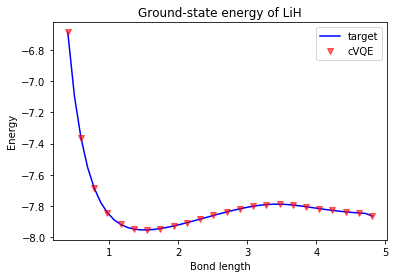

In [11]:
plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.title("Ground-state energy of LiH")
plt.plot(bond_distances, energies_from_thetas,"b-",
         label="target")
plt.plot(bond_distances, snake_energies, "rv",ms=6,alpha=0.6,markevery=2,
         label="cVQE")

plt.legend()
plt.savefig("energy_LiH.jpg",dpi=300)
plt.show()

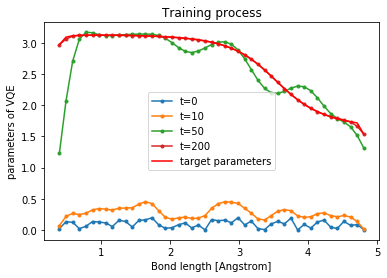

In [14]:
#real_thetas=np.loadtxt("thetas_circuit.txt")

plt.figure()
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("parameters of VQE")
plt.title("Training process")
#for i in range(len(theta_history)):

plt.plot(bond_distances, theta_history[0][:,0],".-",label='t=0')    
#plt.plot(bond_distances, theta_array[199,:,0],".-",label='t=200')
plt.plot(bond_distances, theta_history[1][:,0],".-",label='t=10')   
plt.plot(bond_distances, theta_history[5][:,0],".-",label='t=50') 
# plt.plot(bond_distances, theta_history[10][:,0],".-",label='t=100')
plt.plot(bond_distances, theta_history[-1][:,0],".-",label='t=200')
#plt.plot(bond_distances, theta_array[399,:,0],".-",label='t=400')   
plt.plot(bond_distances, real_thetas[:,0],"r-",label='target parameters')
plt.legend()
plt.show()

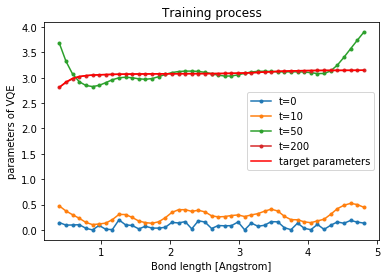

In [15]:
#real_thetas=np.loadtxt("thetas_circuit.txt")

plt.figure()
plt.xlabel("Bond length [Angstrom]")
plt.ylabel("parameters of VQE")
plt.title("Training process")
#for i in range(len(theta_history)):

plt.plot(bond_distances, theta_history[0][:,1],".-",label='t=0')    
#plt.plot(bond_distances, theta_array[199,:,0],".-",label='t=200')
plt.plot(bond_distances, theta_history[1][:,1],".-",label='t=10')   
plt.plot(bond_distances, theta_history[5][:,1],".-",label='t=50') 
# plt.plot(bond_distances, thetas_history[10][:,1],".-",label='t=100')
plt.plot(bond_distances, theta_history[-1][:,1],".-",label='t=200')
#plt.plot(bond_distances, theta_array[399,:,0],".-",label='t=400')   
plt.plot(bond_distances, real_thetas[:,1],"r-",label='target parameters')
plt.legend()
plt.show()

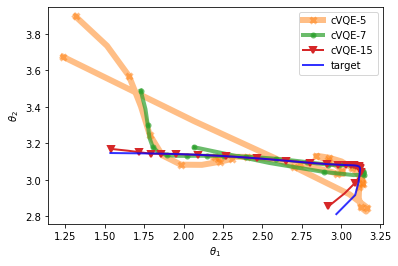

In [16]:
#real_thetas=np.loadtxt("thetas_circuit.txt")

plt.figure()
plt.xlabel("$\\theta_1$")
plt.ylabel("$\\theta_2$")
#plt.title("Evolving snake for VQE")
#for i in range(len(theta_history)):


plt.plot(theta_history[5][:,0], theta_history[5][:,1],"C1x-",mew=3,lw ='6',alpha=0.5,markevery=2,label='cVQE-5') 
plt.plot(theta_history[7][:,0], theta_history[7][:,1],"C2.-",mew=3,lw ='4',alpha=0.7,markevery=2,label='cVQE-7') 
#plt.plot(theta_history[10][:,0], theta_history[10][:,1],"+-",label='snake-10') 
plt.plot(theta_history[15][:,0], theta_history[15][:,1],"C3v-",mew=2,lw ='2',alpha=1.0,markevery=2,label='cVQE-15') 
#plt.plot(theta_history[20][:,0], theta_history[20][:,1],"1",label='snake-20') 
plt.plot(real_thetas[:,0], real_thetas[:,1],"b-",lw ='2',alpha=0.8,label='target')
plt.legend()
plt.savefig("evolving_snake_LiH.jpg",dpi=300)

plt.show()

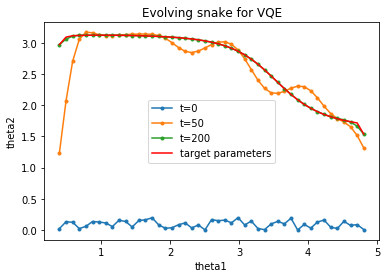

In [17]:
#real_thetas=np.loadtxt("thetas_circuit.txt")

plt.figure()
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("Evolving snake for VQE")
#for i in range(len(theta_history)):

plt.plot(bond_distances, theta_history[0][:,0],".-",label='t=0')    
#plt.plot(bond_distances, theta_array[199,:,0],".-",label='t=200')
plt.plot(bond_distances, theta_history[5][:,0],".-",label='t=50')   
# plt.plot(bond_distances, theta_history[10][:,0],".-",label='t=100') 
plt.plot(bond_distances, theta_history[-1][:,0],".-",label='t=200')
#plt.plot(bond_distances, theta_array[399,:,0],".-",label='t=400')   
plt.plot(bond_distances, real_thetas[:,0],"r-",label='target parameters')
plt.legend()
plt.show()